In [1]:
#imports
import os
import sys
import io
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import pandas as pd
import numpy as np
import joblib
from datetime import datetime
import matplotlib.pyplot as plt
import math

import torch
import torch.nn as nn
import torch.optim as optim
#from torchinfo import summary
#import torchvision.transforms.functional as F
import torch.nn.functional as F
from torchvision.transforms import InterpolationMode
from torchvision import datasets, transforms
from torch.utils.data import Dataset,DataLoader
from torchvision.models import resnet50, ResNet50_Weights, resnet18, ResNet18_Weights
#from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim.lr_scheduler import LambdaLR

from tqdm import tqdm

import cv2
from PIL import Image
source_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(source_path)

# Definitions

## transforms

In [87]:
transform_resnet = transforms.Compose([
                    transforms.Resize(256, interpolation=transforms.InterpolationMode.BILINEAR),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ])

In [88]:
# ------------------------------
# Data Augmentation for Contrastive Learning
# ------------------------------
color_jitter = transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1)

ContrastiveTransform = transforms.Compose([
    transforms.RandomResizedCrop(256, scale=(0.8, 1.0), interpolation=InterpolationMode.BILINEAR),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([color_jitter], p=0.8),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.5),
    transforms.ToTensor(),
])

In [264]:
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], 
    std=[0.229, 0.224, 0.225]
)
color_jitter_strength = 0.3
image_size=224
# SimCLR data augmentation transform
simclr_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=image_size, scale=(0.6, 1.0)),
    #transforms.RandomHorizontalFlip(),
    transforms.RandomApply([
        transforms.ColorJitter(
                    brightness=color_jitter_strength,
                    contrast=color_jitter_strength,
                    saturation=color_jitter_strength,
                    hue=0.05)
            ], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.GaussianBlur(5, sigma=(0.1, 0.5)),  # kernel_size ~ 0.1 * image size
    transforms.RandomAffine(degrees=3, translate=(0.02, 0.02),shear=3),
    transforms.ToTensor(),
    normalize
])

## dataloaders

In [90]:
class CustomPatchDataset(Dataset):
    def __init__(self, df,transform=ContrastiveTransform):
        """
        Args:
            image_dirs (list of str): List of directories to load images from.
            labels_df (DataFrame): DataFrame containing labeled images.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.image_files = df['file_name'].tolist()
        self.x1 = df['x'].tolist()
        self.y1 = df['y'].tolist()
        self.x2 = df['x2'].tolist()
        self.y2 = df['y2'].tolist()
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        x1=self.x1[idx]
        y1=self.y1[idx]
        x2=self.x2[idx]
        y2=self.y2[idx]
        image = Image.open(img_path).convert("RGB")
        patch = image.crop((x1, y1, x2, y2))

        if self.transform:
            patch1 = self.transform(patch)
            patch2 = self.transform(patch)

        return {
            'image1': patch1,
            'image2': patch2,
        }

## model

In [91]:
class ContrastiveModel(nn.Module):
    """ResNet Backbone + Projection Head for SimCLR."""
    def __init__(self, model, in_features,projection_dim=128,hidden_dim=256):
        super().__init__()
        self.encoder = model
        self.encoder.fc = nn.Identity()  # Remove the classification head
        self.projection_head = nn.Sequential(
            nn.Linear(in_features, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, projection_dim)
        )

    def forward(self, x):
        features = self.encoder(x)
        projections = self.projection_head(features)
        return F.normalize(projections, dim=1)

## loss

In [92]:
# ------------------------------
# NT-Xent Contrastive Loss
# ------------------------------
class NTXentLoss(nn.Module):
    """Normalized Temperature-scaled Cross Entropy Loss (SimCLR)."""
    def __init__(self, temperature=0.5, verbose=False):
        super().__init__()
        self.temperature = temperature
        self.criterion = nn.CrossEntropyLoss()
        self.verbose = verbose

    def forward(self, z_i, z_j):
        verbose = self.verbose
        batch_size = z_i.shape[0]
        z = torch.cat([z_i, z_j], dim=0)  # Stack positive pairs
        similarity_matrix = torch.matmul(z, z.T)  # Cosine similarity
        #I don't normalize because the model already does it in the forward pass
        
        # Remove self-similarity
        mask = torch.eye(2 * batch_size, dtype=torch.bool, device=z.device)
        similarity_matrix = similarity_matrix[~mask].view(2 * batch_size, -1)
        if verbose:
            print("similarity_matrix: ",similarity_matrix.shape)
            print(similarity_matrix)
        
        # Compute positive pairs similarity
        '''
        positives = torch.cat([torch.diag(similarity_matrix, batch_size-1), 
                               torch.diag(similarity_matrix, -batch_size+1)], dim=0)
        '''
        
        # Compute NT-Xent loss
        #labels = torch.arange(2 * batch_size, device=z.device)
        labels = torch.cat([torch.arange(batch_size-1,2*batch_size-1, device=z.device),
                            torch.arange(batch_size, device=z.device)], dim=0)
        if verbose:
            print("labels: ",labels.shape)
            print(labels)
        
        # Each row should have the highest score at its label index to be used by the crossentropy loss
        loss = self.criterion(similarity_matrix / self.temperature, labels)
        #labels should be the class indexes. The first argument are the logits.
        return loss
    

In [93]:
class NTXentLoss_chat(nn.Module):
    def __init__(self, temperature=0.5):
        super().__init__()
        self.temperature = temperature

    def forward(self, z_i, z_j):
        batch_size = z_i.size(0)
        z = torch.cat([z_i, z_j], dim=0)  # [2N, D]

        # Cosine similarity matrix
        sim = F.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0), dim=2)  # [2N, 2N]
        sim = sim / self.temperature

        # Mask out self-similarities
        mask = torch.eye(2 * batch_size, device=z.device).bool()
        sim.masked_fill_(mask, -float('inf'))

        # Positive indices: for i in [0, 2N), positive pair is at i + N (mod 2N)
        pos_idx = torch.arange(2 * batch_size, device=z.device)
        pos_pair_idx = (pos_idx + batch_size) % (2 * batch_size)

        # Compute loss
        loss = F.cross_entropy(sim, pos_pair_idx)
        return loss


## optimizers and hyperparameters

In [94]:
'''class LARS(Optimizer):
    def __init__(self, params, lr, weight_decay=1e-6, momentum=0.9, eta=0.001, eps=1e-9):
        defaults = dict(lr=lr, weight_decay=weight_decay, momentum=momentum,
                        eta=eta, eps=eps)
        super(LARS, self).__init__(params, defaults)

    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                dp = p.grad.data

                if group['weight_decay'] != 0:
                    dp = dp.add(group['weight_decay'], p.data)

                param_norm = torch.norm(p.data)
                grad_norm = torch.norm(dp)
                one = torch.ones_like(param_norm)

                q = torch.where(param_norm > 0,
                                torch.where(grad_norm > 0,
                                            (group['eta'] * param_norm / (grad_norm + group['eps'])),
                                            one),
                                one)

                dp = dp.mul(q)

                if group.get('momentum', 0) > 0:
                    param_state = self.state[p]
                    if 'momentum_buffer' not in param_state:
                        buf = param_state['momentum_buffer'] = torch.clone(dp).detach()
                    else:
                        buf = param_state['momentum_buffer']
                        buf.mul_(group['momentum']).add_(dp)
                    dp = buf

                p.data.add_(-group['lr'], dp)'''

"class LARS(Optimizer):\n    def __init__(self, params, lr, weight_decay=1e-6, momentum=0.9, eta=0.001, eps=1e-9):\n        defaults = dict(lr=lr, weight_decay=weight_decay, momentum=momentum,\n                        eta=eta, eps=eps)\n        super(LARS, self).__init__(params, defaults)\n\n    def step(self):\n        for group in self.param_groups:\n            for p in group['params']:\n                if p.grad is None:\n                    continue\n\n                dp = p.grad.data\n\n                if group['weight_decay'] != 0:\n                    dp = dp.add(group['weight_decay'], p.data)\n\n                param_norm = torch.norm(p.data)\n                grad_norm = torch.norm(dp)\n                one = torch.ones_like(param_norm)\n\n                q = torch.where(param_norm > 0,\n                                torch.where(grad_norm > 0,\n                                            (group['eta'] * param_norm / (grad_norm + group['eps'])),\n                              

## scheduling

In [95]:
def get_cosine_schedule_with_warmup(optimizer, warmup_epochs, total_epochs):
    def lr_lambda(current_epoch):
        if current_epoch < warmup_epochs:
            return float(current_epoch) / float(max(1, warmup_epochs))
        progress = float(current_epoch - warmup_epochs) / float(max(1, total_epochs - warmup_epochs))
        return 0.5 * (1. + math.cos(math.pi * progress))
    return LambdaLR(optimizer, lr_lambda)

## train loop

In [96]:
def train_lars(model, dataloader, device, n_epochs):
    model = model.to(device)

    base_lr = 4.8
    batch_size = 4096
    effective_lr = base_lr * (batch_size / 256)
    optimizer = LARS(model.parameters(), lr=effective_lr, weight_decay=1e-6)
    scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_epochs=10, total_epochs=100)

    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0
        for (x1, x2) in tqdm(dataloader, desc=f"Epoch {epoch+1}"):
            x = torch.cat([x1, x2], dim=0).to(device)

            z = model(x)
            loss = NTXentLoss(z)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        scheduler.step()
        print(f"Epoch {epoch+1} Loss: {epoch_loss / len(dataloader):.4f}")

In [97]:
def train_val(
    model,
    train_dataloader,
    val_dataloader,
    device,
    base_lr,
    warmup_epochs=10,
    total_epochs=100,
    checkpoint_path='checkpoint.pt',
    plot_every=5,
    early_stopping_patience=10, loss_fn=NTXentLoss(temperature=0.5),
):
    model = model.to(device)
    def get_model_size_mb(model):
        buffer = io.BytesIO()
        torch.save(model.state_dict(), buffer)
        size_mb = buffer.getbuffer().nbytes / 1e6
        return size_mb

    model_size_mb = get_model_size_mb(model)
    print(f"Model size: {model_size_mb:.2f} MB")

    optimizer = torch.optim.Adam(model.parameters(), lr=base_lr)
    scheduler = get_cosine_schedule_with_warmup(
        optimizer, warmup_epochs=warmup_epochs, total_epochs=total_epochs
    )
    loss_fn = loss_fn

    # Initialize tracking variables
    start_epoch = 0
    train_losses = []
    val_losses = []
    lrs = []
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    # Optional Resume from checkpoint
    if os.path.exists(checkpoint_path):
        print(f"🔄 Resuming from checkpoint: {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch']
        best_val_loss = checkpoint['best_val_loss']
        train_losses = checkpoint.get('train_losses', [])
        val_losses = checkpoint.get('val_losses', [])
        lrs = checkpoint.get('lrs', [])
    else:
        print(f"📂 No checkpoint found at {checkpoint_path}. Starting fresh training.")

    for epoch in range(start_epoch, total_epochs):
        model.train()
        epoch_train_loss = 0

        for idx,batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{total_epochs} [Train]")):
            x_i, x_j = batch['image1'].to(device), batch['image2'].to(device)
            z_i, z_j = model(x_i), model(x_j)
            loss = loss_fn(z_i, z_j)

            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            
            optimizer.step()
            '''del x_i, x_j, z_i, z_j, loss  # clear references
            torch.cuda.empty_cache()  # optional, helps if memory gets fragmented'''

            epoch_train_loss += loss.item()

            '''if idx % 50 == 0:  # Print every 100 batches
                before = torch.cuda.memory_allocated() / 1e6
                before_reserved = torch.cuda.memory_reserved() / 1e6
                print(f"[GPU Memory] Allocated: {before:.2f} MB | Reserved: {before_reserved:.2f} MB")'''

        avg_train_loss = epoch_train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)
        lrs.append(optimizer.param_groups[0]['lr'])

        # Validation
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for batch in tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{total_epochs} [Val]"):
                x_i, x_j = batch['image1'].to(device), batch['image2'].to(device)
                z_i, z_j = model(x_i), model(x_j)
                loss = loss_fn(z_i, z_j)
                epoch_val_loss += loss.item()
        avg_val_loss = epoch_val_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)

        scheduler.step()

        # Logging
        print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | LR: {lrs[-1]:.6f}")

        # Checkpointing based on val loss
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_val_loss': best_val_loss,
                'train_losses': train_losses,
                'val_losses': val_losses,
                'lrs': lrs
            }
            torch.save(checkpoint, checkpoint_path)
            epochs_without_improvement = 0
            print(f"✅ Saved new best model at epoch {epoch+1}")
        else:
            epochs_without_improvement += 1
            print(f"⏳ No improvement for {epochs_without_improvement} epoch(s)")

        # Early stopping
        if epochs_without_improvement >= early_stopping_patience:
            print(f"⛔ Early stopping at epoch {epoch+1} (no improvement for {early_stopping_patience} epochs)")
            break

        # Plot every `plot_every` epochs
        if (epoch + 1) % plot_every == 0 or (epoch + 1) == total_epochs:
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.plot(train_losses, label="Train Loss")
            plt.plot(val_losses, label="Val Loss")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.legend()

            plt.subplot(1, 2, 2)
            plt.plot(lrs, label="Learning Rate", color='orange')
            plt.xlabel("Epoch")
            plt.ylabel("LR")
            plt.legend()

            plt.suptitle(f"Epoch {epoch+1}")
            plt.tight_layout()
            plt.show()


In [98]:
def train(
    model,
    train_dataloader,
    val_dataloader,
    device,
    base_lr,
    warmup_epochs=10,
    total_epochs=100,
    checkpoint_path='checkpoint.pt',
    plot_every=5,
    early_stopping_patience=10, loss_fn=NTXentLoss(temperature=0.5),
):
    model = model.to(device)
    def get_model_size_mb(model):
        buffer = io.BytesIO()
        torch.save(model.state_dict(), buffer)
        size_mb = buffer.getbuffer().nbytes / 1e6
        return size_mb

    model_size_mb = get_model_size_mb(model)
    print(f"Model size: {model_size_mb:.2f} MB")

    optimizer = torch.optim.Adam(model.parameters(), lr=base_lr)
    scheduler = get_cosine_schedule_with_warmup(
        optimizer, warmup_epochs=warmup_epochs, total_epochs=total_epochs
    )
    loss_fn = loss_fn

    # Initialize tracking variables
    start_epoch = 0
    train_losses = []
    lrs = []
    best_train_loss = float('inf')
    epochs_without_improvement = 0

    # Optional Resume from checkpoint
    if os.path.exists(checkpoint_path):
        print(f"🔄 Resuming from checkpoint: {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch']
        best_train_loss = checkpoint['best_val_loss']
        train_losses = checkpoint.get('train_losses', [])
        lrs = checkpoint.get('lrs', [])
    else:
        print(f"📂 No checkpoint found at {checkpoint_path}. Starting fresh training.")

    for epoch in range(start_epoch, total_epochs):
        model.train()
        epoch_train_loss = 0

        for idx,batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{total_epochs} [Train]")):
            x_i, x_j = batch['image1'].to(device), batch['image2'].to(device)
            z_i, z_j = model(x_i), model(x_j)
            loss = loss_fn(z_i, z_j)

            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            
            optimizer.step()
            '''del x_i, x_j, z_i, z_j, loss  # clear references
            torch.cuda.empty_cache()  # optional, helps if memory gets fragmented'''

            epoch_train_loss += loss.item()

            '''if idx % 50 == 0:  # Print every 100 batches
                before = torch.cuda.memory_allocated() / 1e6
                before_reserved = torch.cuda.memory_reserved() / 1e6
                print(f"[GPU Memory] Allocated: {before:.2f} MB | Reserved: {before_reserved:.2f} MB")'''

        avg_train_loss = epoch_train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)
        lrs.append(optimizer.param_groups[0]['lr'])

        scheduler.step()

        # Logging
        print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | LR: {lrs[-1]:.6f}")

        # Checkpointing based on train loss
        if avg_train_loss < best_train_loss:
            best_train_loss = avg_train_loss
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_train_loss': best_train_loss,
                'train_losses': train_losses,
                'lrs': lrs
            }
            torch.save(checkpoint, checkpoint_path)
            epochs_without_improvement = 0
            print(f"✅ Saved new best model at epoch {epoch+1}")
        else:
            epochs_without_improvement += 1
            print(f"⏳ No improvement for {epochs_without_improvement} epoch(s)")

        # Early stopping
        if epochs_without_improvement >= early_stopping_patience:
            print(f"⛔ Early stopping at epoch {epoch+1} (no improvement for {early_stopping_patience} epochs)")
            break

        # Plot every `plot_every` epochs
        if (epoch + 1) % plot_every == 0 or (epoch + 1) == total_epochs:
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.plot(train_losses, label="Train Loss")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.legend()

            plt.subplot(1, 2, 2)
            plt.plot(lrs, label="Learning Rate", color='orange')
            plt.xlabel("Epoch")
            plt.ylabel("LR")
            plt.legend()

            plt.suptitle(f"Epoch {epoch+1}")
            plt.tight_layout()
            plt.show()

In [99]:
def pretrain_contrastive(model, dataloader, optimizer, device, epochs=10):
    model.train()
    loss_fn = NTXentLoss()
    
    for epoch in range(epochs):
        epoch_loss = 0
        for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            x_i, x_j = batch['image1'], batch['image2']
            x_i, x_j = x_i.to(device), x_j.to(device)
            z_i, z_j = model(x_i), model(x_j)
            loss = loss_fn(z_i, z_j)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(dataloader):.4f}")

## t-sne visualization

In [100]:
'''# After pretraining
features, labels = [], []
with torch.no_grad():
    for x, y in dataloader:
        x = x.to(device)
        z = model(x)
        features.append(z.cpu())
        labels.append(y)
# Plot t-SNE of concatenated features'''

'# After pretraining\nfeatures, labels = [], []\nwith torch.no_grad():\n    for x, y in dataloader:\n        x = x.to(device)\n        z = model(x)\n        features.append(z.cpu())\n        labels.append(y)\n# Plot t-SNE of concatenated features'

## measure

In [101]:
def get_size_of_image_on_model(model, device, input_shape=(3, 224, 224), contrastive=True,batches=5):
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
    before = torch.cuda.memory_allocated() / 1e6
    before_reserved = torch.cuda.memory_reserved() / 1e6
    print(f"[GPU Memory] Allocated before model loading: {before:.2f} MB | Reserved: {before_reserved:.2f} MB")
    model = model.to(device)
    after = torch.cuda.memory_allocated() / 1e6
    after_reserved = torch.cuda.memory_reserved() / 1e6
    print(f"[GPU Memory] Allocated after model loading: {after:.2f} MB | Reserved: {after_reserved:.2f} MB")
    print(f"[GPU Memory] DELTA: {after-before:.2f} MB | Reserved: {after_reserved-before_reserved:.2f} MB")
    print("-" * 50)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    scheduler = get_cosine_schedule_with_warmup(
        optimizer, warmup_epochs=10, total_epochs=100
    )
    loss_fn = NTXentLoss()

    model.train()
    batch = {
        'image1': torch.rand((batches, *input_shape), device=device),
        'image2': torch.rand((batches, *input_shape), device=device)
    }
    x_i, x_j = batch['image1'].to(device), batch['image2'].to(device)
    allocated_image = tensor_memory_mb(x_i)
    print(f"x_i memory: {allocated_image:.2f} MB")
    print('batch size:', x_i.shape[0])

    before = torch.cuda.memory_allocated() / 1e6
    before_reserved = torch.cuda.memory_reserved() / 1e6
    print(f"[GPU Memory] Allocated before model forward pass: {before:.2f} MB | Reserved: {before_reserved:.2f} MB")
    z_i, z_j = model(x_i), model(x_j)
    after = torch.cuda.memory_allocated() / 1e6
    after_reserved = torch.cuda.memory_reserved() / 1e6
    print(f"[GPU Memory] Allocated after model forward pass: {after:.2f} MB | Reserved: {after_reserved:.2f} MB")
    print(f"[GPU Memory] DELTA: {after-before:.2f} MB | Reserved: {after_reserved-before_reserved:.2f} MB")
    print("-" * 50)
    if contrastive:
        loss = loss_fn(z_i, z_j)
    else:
        loss = F.mse_loss(z_i, z_j)
    optimizer.zero_grad(set_to_none=True)
    before = torch.cuda.memory_allocated() / 1e6
    before_reserved = torch.cuda.memory_reserved() / 1e6
    print(f"[GPU Memory] Allocated before backward pass: {before:.2f} MB | Reserved: {before_reserved:.2f} MB")
    loss.backward()
    after = torch.cuda.memory_allocated() / 1e6
    after_reserved = torch.cuda.memory_reserved() / 1e6
    print(f"[GPU Memory] Allocated after backward pass: {after:.2f} MB | Reserved: {after_reserved:.2f} MB")
    print(f"[GPU Memory] DELTA: {after-before:.2f} MB | Reserved: {after_reserved-before_reserved:.2f} MB")
    print("-" * 50)
'''
import gc
import torch
import objgraph

gc.collect()
tensors = [obj for obj in gc.get_objects() if torch.is_tensor(obj) and obj.is_cuda]

print(f"Found {len(tensors)} CUDA tensors occupying memory:")
for i, t in enumerate(tensors):
print(f"Tensor {i}: shape={t.shape}, dtype={t.dtype}, size={t.element_size() * t.nelement() / 1024**2:.2f} MB")'''

'\nimport gc\nimport torch\nimport objgraph\n\ngc.collect()\ntensors = [obj for obj in gc.get_objects() if torch.is_tensor(obj) and obj.is_cuda]\n\nprint(f"Found {len(tensors)} CUDA tensors occupying memory:")\nfor i, t in enumerate(tensors):\nprint(f"Tensor {i}: shape={t.shape}, dtype={t.dtype}, size={t.element_size() * t.nelement() / 1024**2:.2f} MB")'

In [102]:
get_size_of_image_on_model(
    ContrastiveModel(resnet50(weights=ResNet50_Weights.IMAGENET1K_V2), in_features=2048, projection_dim=128),
    device='cuda',
    input_shape=(3, 224, 224), contrastive = True, batches = 1 
)
print("$$" * 50)
get_size_of_image_on_model(
    ContrastiveModel(resnet50(weights=ResNet50_Weights.IMAGENET1K_V2), in_features=2048, projection_dim=128),
    device='cuda',
    input_shape=(3, 224, 224), contrastive = True, batches = 32
)
print(torch.cuda.memory_summary(device='cuda', abbreviated=True))

[GPU Memory] Allocated before model loading: 17.04 MB | Reserved: 41.94 MB
[GPU Memory] Allocated after model loading: 114.60 MB | Reserved: 144.70 MB
[GPU Memory] DELTA: 97.56 MB | Reserved: 102.76 MB
--------------------------------------------------
x_i memory: 0.57 MB
batch size: 1
[GPU Memory] Allocated before model forward pass: 115.80 MB | Reserved: 146.80 MB
[GPU Memory] Allocated after model forward pass: 288.03 MB | Reserved: 308.28 MB
[GPU Memory] DELTA: 172.23 MB | Reserved: 161.48 MB
--------------------------------------------------
[GPU Memory] Allocated before backward pass: 288.04 MB | Reserved: 308.28 MB
[GPU Memory] Allocated after backward pass: 215.02 MB | Reserved: 394.26 MB
[GPU Memory] DELTA: -73.02 MB | Reserved: 85.98 MB
--------------------------------------------------
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
[GPU Memory] Allocated before model loading: 17.04 MB | Reserved: 41.94 MB
[GPU Memory] All

In [103]:
get_size_of_image_on_model(
    ContrastiveModel(resnet18(weights='IMAGENET1K_V1'), in_features=512, projection_dim=128),
    device='cuda',
    input_shape=(3, 224, 224)
)

[GPU Memory] Allocated before model loading: 17.04 MB | Reserved: 41.94 MB
[GPU Memory] Allocated after model loading: 62.88 MB | Reserved: 90.18 MB
[GPU Memory] DELTA: 45.84 MB | Reserved: 48.23 MB
--------------------------------------------------
x_i memory: 2.87 MB
batch size: 5
[GPU Memory] Allocated before model forward pass: 68.90 MB | Reserved: 90.18 MB
[GPU Memory] Allocated after model forward pass: 292.26 MB | Reserved: 312.48 MB
[GPU Memory] DELTA: 223.36 MB | Reserved: 222.30 MB
--------------------------------------------------
[GPU Memory] Allocated before backward pass: 292.27 MB | Reserved: 312.48 MB
[GPU Memory] Allocated after backward pass: 115.28 MB | Reserved: 390.07 MB
[GPU Memory] DELTA: -176.99 MB | Reserved: 77.59 MB
--------------------------------------------------


# Initialization

In [80]:
import random

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

In [81]:
source_file="icdar_train_df_iam_rimes_patches_20250615_170212.csv"
running = 'new-laptop'
saved = 'new-laptop'
pretrained = True
selected_model='resnet50'
train_df = pd.read_csv(f"{source_path}\\outputs\\preprocessed_data\\{source_file}")
train_df=file_IO.change_filename_from_to(train_df, fr=saved, to=running)

In [82]:
#cahtgpt suggests
initial_lr = 3e-4
weight_decay=1e-6
batch_size = 32
temperature=0.5
checkpoint_path = f"{source_path}\\outputs\\models\\contrastive\\checkpoint.pt"
p_train=0.9

In [83]:
if selected_model == 'resnet50':
    weights = ResNet50_Weights.IMAGENET1K_V1 if pretrained else None
    model = resnet50(weights=weights)
else:
    raise ValueError(f"Model {selected_model} is not supported.")
in_features = model.fc.in_features
print(f"Model in_features: {in_features}")

Model in_features: 2048


In [84]:
train_dataset = CustomPatchDataset(train_df ,transform=simclr_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#val_dataset = CustomPatchDataset(train_df[(train_df['train']==0) & (train_df['index']<=N_max)] , transform=simclr_transform)
#val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9466565..1.6813945].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.141793..2.5702832].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.02868402..1.6291069].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.8446785..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.056939743..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8781574..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9466565..2.291416

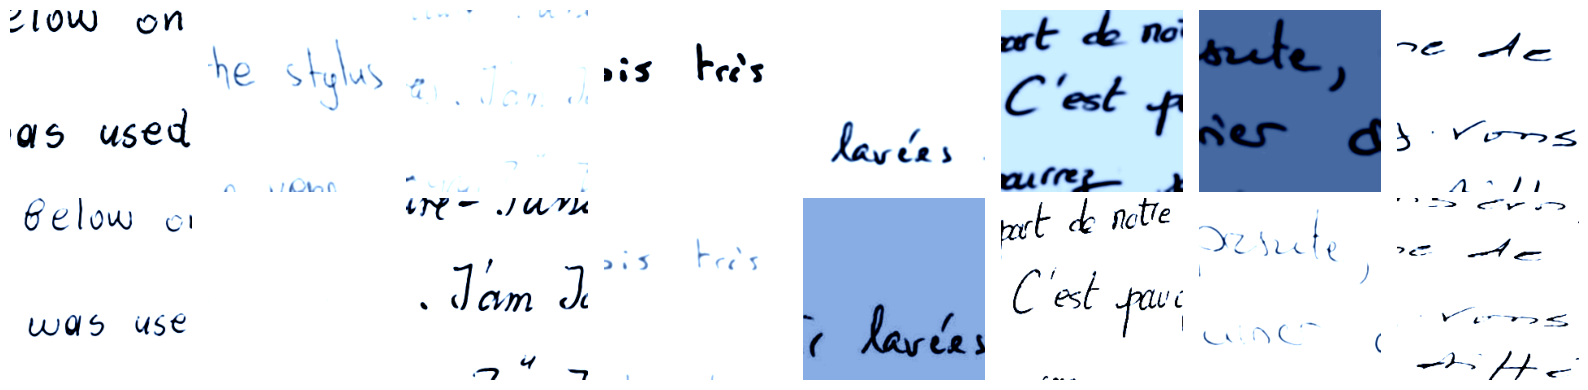

Memory used for plotting: 9.19 MB


In [85]:
# Create an iterator
data_iter = iter(train_dataloader)
# Get a single batch
batch = next(data_iter)
plot_image_batches(batch['image1'], batch['image2'])

In [86]:
contrastive_model = ContrastiveModel(model, in_features=in_features,projection_dim=128)

# run

In [156]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(f"[GPU Memory] Allocated: {torch.cuda.memory_allocated() / 1e6:.2f} MB | Reserved: {torch.cuda.memory_reserved() / 1e6:.2f} MB")

cuda
[GPU Memory] Allocated: 1518.65 MB | Reserved: 7446.99 MB


In [ ]:
train(
    contrastive_model,
    train_dataloader,
    device,
    initial_lr,
    warmup_epochs=10,
    total_epochs=100,
    checkpoint_path=checkpoint_path,
    plot_every=5,
    early_stopping_patience=5, loss_fn=NTXentLoss_chat(temperature=0.5)
)

Model size: 96.58 MB
📂 No checkpoint found at c:\Users\andre\VsCode\PD related projects\gender_detection\outputs\models\contrastive\checkpoint.pt. Starting fresh training.


Epoch 1/100 [Val]: 100%|██████████| 114/114 [02:40<00:00,  1.41s/it]


Epoch 1 | Train Loss: 4.0986 | Val Loss: 4.0966 | LR: 0.000000
✅ Saved new best model at epoch 1


Epoch 2/100 [Val]: 100%|██████████| 114/114 [02:47<00:00,  1.47s/it]


Epoch 2 | Train Loss: 3.0675 | Val Loss: 2.9551 | LR: 0.000030
✅ Saved new best model at epoch 2


Epoch 3/100 [Val]: 100%|██████████| 114/114 [02:48<00:00,  1.48s/it]


Epoch 3 | Train Loss: 2.9110 | Val Loss: 2.9085 | LR: 0.000060
✅ Saved new best model at epoch 3


Epoch 4/100 [Val]: 100%|██████████| 114/114 [02:44<00:00,  1.44s/it]


Epoch 4 | Train Loss: 2.8845 | Val Loss: 2.9175 | LR: 0.000090
⏳ No improvement for 1 epoch(s)


Epoch 5/100 [Train]:   3%|▎         | 29/1002 [00:50<28:27,  1.75s/it]


KeyboardInterrupt: 

In [ ]:
1/0

ZeroDivisionError: division by zero

In [ ]:
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
!nvidia-smi

Mon Jun 16 17:45:53 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.52                 Driver Version: 576.52         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   40C    P8              7W /   55W |    7935MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# save

In [ ]:
experiment = datetime.now().strftime("%Y%m%d_%H%M%S")
out_dir = os.path.join(source_path, "outputs", "logs")
# Example usage:
LOG_OUT_FILE = out_dir+"\\feature_extraction_metadata_log.json"
print(f"Log file path: {LOG_OUT_FILE}")
file_IO.add_or_update_experiment(
    experiment, LOG_OUT_FILE,
    custom_metadata={
        "original raw file": source_data,
        "input file": input_file_name,
        "FE model": model_used,
        "FE transform": transform_used,
        "classifier model": selected_model,
        "model_params": feature_extraction_model[selected_model].get_params(),
        "n_splits": n_splits,
        "train_on_language": train_on_language,
        "train_on_same": train_on_same,
        "task": task,
        "with cross validation": with_cross_validation,
        "with PCA": with_pca,
        "training time for cross-validation": time_taken_cross_val,
        "training time for final model": time_taken,
        "cross_val_accuracies": cross_val_accuracies,
        "subgroup_accuracies": subgroup_accuracies,
        "is_kaggle": is_kaggle,
        "test": 'this is a test column',
        "description": ''' I am training a classifier on the feature vectors extracted by a deep model
        I am evaluating the results on subsets of the training data, based on language and same/different text.''' 
    }
)

# random tests

## tests on transformations

In [172]:
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], 
    std=[0.229, 0.224, 0.225]
)
color_jitter_strength = 0.3
image_size=224
# SimCLR data augmentation transform
strong_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=image_size, scale=(0.6, 1.0)),
    #transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.ColorJitter(brightness=color_jitter_strength,contrast=color_jitter_strength,saturation=color_jitter_strength,
                   hue=0.05)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.GaussianBlur(5, sigma=(0.1, 0.5)),  # kernel_size ~ 0.1 * image size'''
    transforms.RandomAffine(degrees=3, translate=(0.02, 0.02), shear=5),
    transforms.ToTensor(),
    normalize
])

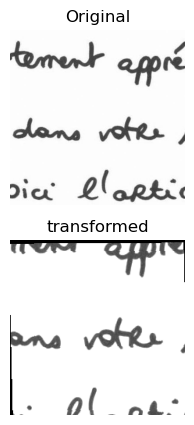

In [263]:
i = 1000  # Change this index as needed
image_path = train_df.iloc[i]['file_name']
x1 = train_df.iloc[i]['x']
y1 = train_df.iloc[i]['y']
x2 = train_df.iloc[i]['x2']
y2 = train_df.iloc[i]['y2']
img = Image.open(image_path).convert('RGB').crop((x1, y1, x2, y2))

def show_images(original, transformed1):
    fig, axs = plt.subplots(2, figsize=(15, 5))
    axs[0].imshow(original)
    axs[0].set_title("Original")
    axs[0].axis('off')

    axs[1].imshow(transformed1.permute(1, 2, 0).numpy())
    axs[1].set_title("transformed")
    axs[1].axis('off')

    plt.show()

# Apply transforms
transformed = strong_transform(img)

# Normalize back to [0,1] for display
def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406])[:, None, None]
    std = torch.tensor([0.229, 0.224, 0.225])[:, None, None]
    tensor = tensor * std + mean
    return torch.clamp(tensor, 0, 1)

show_images(
    img,
    denormalize(transformed)
)

## tests on contrastive learning

In [78]:
class RandomTensorDataset(Dataset):
    def __init__(self, num_samples, image_size=(256, 256, 3)):
        self.num_samples = num_samples
        self.image_size = image_size

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        tensor1 = torch.rand(*self.image_size).permute(2, 0, 1)  # Convert to (C, H, W)
        #tensor2 = torch.rand(*self.image_size).permute(2, 0, 1)  # Convert to (C, H, W)
        tensor2 = tensor1.clone()
        return tensor1, tensor2

# Create the dataset and dataloader
random_dataset = RandomTensorDataset(num_samples=1000)
random_dataloader = DataLoader(random_dataset, batch_size=15, shuffle=True)

# Example: Fetch a batch
random_batch = next(iter(random_dataloader))
print(f"Batch tensor1 shape: {random_batch[0].shape}")
print(f"Batch tensor2 shape: {random_batch[1].shape}")

Batch tensor1 shape: torch.Size([15, 3, 256, 256])
Batch tensor2 shape: torch.Size([15, 3, 256, 256])


In [79]:
weights = ResNet50_Weights.IMAGENET1K_V1 
model = resnet50(weights=weights)
contrastive_model = ContrastiveModel(model, in_features=2048, projection_dim=128)

In [80]:
x_i,x_j = random_batch[0],random_batch[1]
z_i, z_j = contrastive_model(x_i), contrastive_model(x_j)
print(f"Batch representation1 shape: {z_i.shape}")
print(f"Batch representation2 shape: {z_j.shape}")

Batch representation1 shape: torch.Size([15, 128])
Batch representation2 shape: torch.Size([15, 128])


In [81]:
print(z_i[0]-z_j[0])

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<SubBackward0>)


In [82]:
loss_fn = NTXentLoss(verbose=True)
loss = loss_fn(z_i, z_j)

similarity_matrix:  torch.Size([30, 29])
tensor([[0.8167, 0.8420, 0.8287, 0.8028, 0.8629, 0.7963, 0.8248, 0.7954, 0.8657,
         0.8111, 0.8016, 0.8066, 0.8522, 0.8174, 1.0000, 0.8167, 0.8420, 0.8287,
         0.8028, 0.8629, 0.7963, 0.8248, 0.7954, 0.8657, 0.8111, 0.8016, 0.8066,
         0.8522, 0.8174],
        [0.8167, 0.8960, 0.8702, 0.8418, 0.8371, 0.8495, 0.8287, 0.7845, 0.8557,
         0.8522, 0.8757, 0.8707, 0.8549, 0.8304, 0.8167, 1.0000, 0.8960, 0.8702,
         0.8418, 0.8371, 0.8495, 0.8287, 0.7845, 0.8557, 0.8522, 0.8757, 0.8707,
         0.8549, 0.8304],
        [0.8420, 0.8960, 0.9105, 0.9053, 0.8980, 0.8769, 0.8923, 0.8544, 0.9001,
         0.9072, 0.9003, 0.8951, 0.8972, 0.8924, 0.8420, 0.8960, 1.0000, 0.9105,
         0.9053, 0.8980, 0.8769, 0.8923, 0.8544, 0.9001, 0.9072, 0.9003, 0.8951,
         0.8972, 0.8924],
        [0.8287, 0.8702, 0.9105, 0.8745, 0.8567, 0.8216, 0.8514, 0.8208, 0.8700,
         0.8743, 0.8419, 0.8471, 0.8542, 0.8427, 0.8287, 0.8702, 0.9105

In [83]:
loss_fn = NTXentLoss_chat()
loss_2 = loss_fn(z_i, z_j)

In [84]:
print(loss, loss_2)

tensor(3.0918, grad_fn=<NllLossBackward0>) tensor(3.0918, grad_fn=<NllLossBackward0>)


# easy access

In [2]:
def reload_modules():
    import importlib
    import utils.image_processing as image_processing
    import utils.file_IO as file_IO
    import utils.visualization as visualization
    import utils.tests as tests

    importlib.reload(file_IO)
    importlib.reload(image_processing)
    importlib.reload(visualization)
    importlib.reload(tests)

    return image_processing, file_IO, visualization, tests
image_processing, file_IO, visualization, tests = reload_modules()

In [3]:
def plot_image_batches(batch1, batch2, n=8, figsize=(16, 4)):
    """
    Plots two batches of images: first row is batch1, second row is batch2.
    Args:
        batch1 (Tensor): Batch of images (B, C, H, W)
        batch2 (Tensor): Batch of images (B, C, H, W)
        n (int): Number of images to plot from each batch
        figsize (tuple): Figure size
    """
    import matplotlib.pyplot as plt

    n = min(n, batch1.shape[0], batch2.shape[0])
    fig, axes = plt.subplots(2, n, figsize=figsize)
    memory=0
    for i in range(n):
        img1 = batch1[i].cpu()
        img2 = batch2[i].cpu()
        # Unnormalize if needed (assuming ImageNet stats)
        '''if img1.shape[0] == 3:
            img1 = img1 * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
            img2 = img2 * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
            img1 = img1.clamp(0,1)
            img2 = img2.clamp(0,1)'''
        axes[0, i].imshow(img1.permute(1, 2, 0).numpy())
        axes[0, i].axis('off')
        axes[1, i].imshow(img2.permute(1, 2, 0).numpy())
        axes[1, i].axis('off')
        memory += 2*tensor_memory_mb(img1)
    axes[0, 0].set_ylabel('Batch 1', fontsize=14)
    axes[1, 0].set_ylabel('Batch 2', fontsize=14)
    plt.tight_layout()
    plt.show()
    print(f"Memory used for plotting: {memory:.2f} MB")

In [4]:
def tensor_memory_mb(tensor):
    """Returns memory occupied by a torch tensor in megabytes (MB)."""
    num_bytes = tensor.element_size() * tensor.nelement()
    return num_bytes / (1024 ** 2)

# Example usage:
# memory_mb = tensor_memory_mb(batch['image1'])
# print(f"Memory occupied: {memory_mb:.2f} MB")